<a href="https://colab.research.google.com/github/araujobma/HistopathologicCancerDetectionCompetition/blob/main/HistopathologicCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Histopathologic Cancer Detection Competition
This notebook explores the Histopathologic Cancer Detection competition dataset and develops a baseline machine learning model. It is part of the deliverables for the Introduction to Deep Learning Course (UC Boulder) on Coursera, Week 3 project assignment.


An overview of the competition can be found here: https://www.kaggle.com/c/histopathologic-cancer-detection/overview.

THis notebook is available at: https://github.com/araujobma/HistopathologicCancerDetectionCompetition/tree/main

## Download and Extract the Histopathologic Cancer Detection Dataset

This section downloads the dataset from Kaggle and extracts its contents for use in this notebook. The steps are outlined below.

In [1]:
#google drive is mounted for persistence of data
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [2]:
proj_folder = "/content/gdrive/MyDrive/HistopathologicCancerDetection/"


In [3]:
#Definition of Kaggle enviroment variables. Can be found on Kaggle configurations
from google.colab import userdata
import os
import shutil

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [9]:
#!kaggle competitions download -c histopathologic-cancer-detection

In [10]:
#copy data to gdrive
#shutil.copy("histopathologic-cancer-detection.zip", proj_folder)

In [28]:
#copy from gdrive if data is not loaded in the notebook environment
shutil.copy(proj_folder + "histopathologic-cancer-detection.zip", "histopathologic-cancer-detection.zip" )

'histopathologic-cancer-detection.zip'

In [12]:
#Unmount gdrive
#drive.flush_and_unmount()

In [29]:
#Unzips the dataset content
!unzip histopathologic-cancer-detection.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train/48b35f391f3022fc0eb48aef4dc1e45fc04962ed.tif  
  inflating: train/48b3e1b8c20751011c95290cc2a319a1c81ff211.tif  
  inflating: train/48b437df579c526bdf7cda83868a5818df3e9347.tif  
  inflating: train/48b4d39000b6da5db16924831112356479f2ad60.tif  
  inflating: train/48b5146724dd77dbd66f0bee5b10dfc348c12a9d.tif  
  inflating: train/48b526e2cb353f1b7e8bd3c563a34095816d360d.tif  
  inflating: train/48b568fcd5677be0bd3754b00f1c5d5ebd4b2824.tif  
  inflating: train/48b5773d7bd6793cf0a635cf9ff6aacb0401e2c9.tif  
  inflating: train/48b587e2b45e27a7e98f5a2899cb3eb8a9a86b77.tif  
  inflating: train/48b5e6d4fa35852b89792eac7982e852a924014b.tif  
  inflating: train/48b63bc8d75c19e319f17fa477726d9ce8647175.tif  
  inflating: train/48b67a0f5f67037444585813c4f782c53cd5dd2c.tif  
  inflating: train/48b67f35680c5091c0a17eadadb1008ff9b1db45.tif  
  inflating: train/48b72cd8fd40468ea42ebb6462ca220a4efec2fa.tif  
  inflating: trai

##Example of an image in the train set

In [14]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
train_labels = pd.read_csv('train_labels.csv')

# Sample 10% of the DataFrame
sampled_train_labels = train_labels.sample(frac=0.10, random_state=42)  # random_state for reproducibility

print(sampled_train_labels.head())

positive_labels_df = sampled_train_labels[sampled_train_labels['label'] == 1]

labels_proportion = sampled_train_labels['label'].value_counts(normalize=True)


print("\nProportions of labels:", labels_proportion)



                                              id  label
107796  d293308913e4a40cebb809d986aa9add65a76bfa      0
11942   fcd55f03496afb4b11598d9c2231e86da318e723      1
163858  5c983c8f14afeffdb098b9f3cbb68488a802b957      0
184810  71bf03e8530348e57ec07d8ce2052f215390c997      0
150958  1533406000e26663c5fadac3bcc3e38285a45bb3      1

Proportions of labels: label
0    0.596173
1    0.403827
Name: proportion, dtype: float64


train/2c0cd91924da0c8644110725aef828fa1086d238.tif


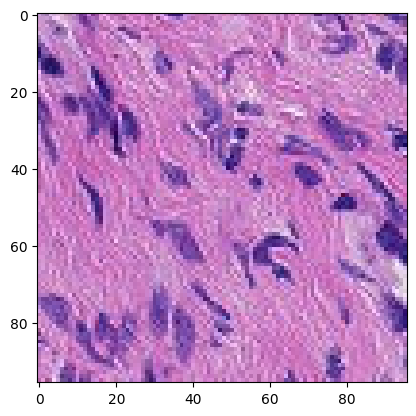

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randint

positive_labels_df = sampled_train_labels[sampled_train_labels['label'] == 1]

#get a sample from the positive labels
sample_img = positive_labels_df.iloc[randint(0, len(positive_labels_df)-1)]['id']

sample_img = sample_img + '.tif'
sample_img_path = 'train/' + sample_img
print(sample_img_path)

img = mpimg.imread(sample_img_path)
plt.imshow(img)
plt.show()


## Feature Extraction: Generating Feature Vectors and Cropping Images to 40x40

In [16]:
import numpy as np
from PIL import Image

def create_feature_vectors(df, image_dir):
    """
    Creates feature vectors from images, image IDs, and labels.

    Args:
        df: Pandas DataFrame with 'id' and 'label' columns.
        image_dir: Path to the directory containing the images.

    Returns:
        Tuple: (feature_vectors, image_ids, labels)
    """
    image_ids = []
    feature_vectors = []
    labels = []

    for index, row in df.iterrows():
        image_id = row['id']
        label = row['label']
        image_path = os.path.join(image_dir, f"{image_id}.tif")

        try:
            # Open the image using Pillow library
            img = Image.open(image_path)
            # Convert the image to RGB mode
            img = img.convert("RGB")

            #Convert pixels to a centered image with dimensions 40x40
            # Calculate the cropping box to center the image
            width, height = img.size
            left = (width - 40) / 2
            top = (height - 40) / 2
            right = (width + 40) / 2
            bottom = (height + 40) / 2
            img = img.crop((left, top, right, bottom))

            # Convert the image to a NumPy array
            pixels = np.array(img) / 255.0 #Normalize pixel values


            image_ids.append(image_id)
            feature_vectors.append(pixels)
            labels.append(label)

        except FileNotFoundError:
            print(f"Image not found: {image_path}")
        except Exception as e:
            print(f"Error processing image {image_id}: {e}")

    return  np.array(image_ids), np.array(feature_vectors), np.array(labels)


image_dir = 'train'
image_ids_np, feature_vectors_np, labels_np = create_feature_vectors(
    #sampled_train_labels,
    train_labels,
    image_dir
)

print("Feature vectors shape:", feature_vectors_np.shape)
print("Image IDs shape:", image_ids_np.shape)
print("Labels shape:", labels_np.shape)

Feature vectors shape: (220025, 40, 40, 3)
Image IDs shape: (220025,)
Labels shape: (220025,)


In [17]:
from sklearn.model_selection import train_test_split

X = feature_vectors_np
y = labels_np

# Split the data into training and testing sets. 80% train, 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (176020, 40, 40, 3)
y_train shape: (176020,)
X_test shape: (44005, 40, 40, 3)
y_test shape: (44005,)


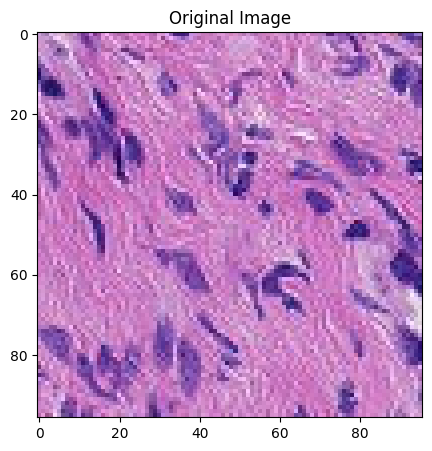

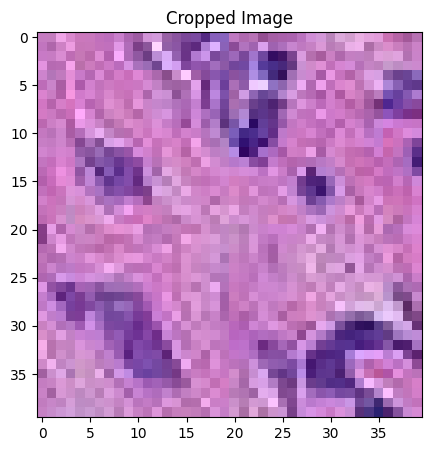

Original Image Index: 63119


In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Find the index of the original image in the 'image_ids' array
original_image_index = np.where(image_ids_np == sample_img[:-4])[0][0]

# Print the original image
original_img_path = 'train/' + sample_img
original_img = mpimg.imread(original_img_path)
plt.figure(figsize=(5, 5))  #
plt.imshow(original_img)
plt.title("Original Image")
plt.show()


# Print the cropped image (from feature vectors)
cropped_img = feature_vectors_np[original_image_index]
plt.figure(figsize=(5, 5))  # Adjust figure size as needed
plt.imshow(cropped_img)
plt.title("Cropped Image")
plt.show()

print("Original Image Index:", original_image_index)

##Building the convolutional model with Tensorflow and Keras


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Input

In [5]:


def numpy_to_tensor(np_array):
    return tf.convert_to_tensor(np_array, dtype=tf.float32)


In [21]:
#Saving numpy arrays for skipping previous steps when re-running this notebook
np.save(proj_folder + "X_train.npy", X_train)
np.save(proj_folder + "y_train.npy", y_train)
np.save(proj_folder + "X_test.npy", X_test)
np.save(proj_folder + "y_test.npy", y_test)

In [ ]:
del train_labels
del sampled_train_labels
del image_ids_np
del feature_vectors_np
del labels_np

In [6]:
#load tensors
import numpy as np
X_train = numpy_to_tensor(np.load(proj_folder + "X_train.npy"))
y_train = numpy_to_tensor(np.load(proj_folder + "y_train.npy"))
X_test = numpy_to_tensor(np.load(proj_folder + "X_test.npy"))
y_test = numpy_to_tensor(np.load(proj_folder + "y_test.npy"))

In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (176020, 40, 40, 3)
y_train shape: (176020,)
X_test shape: (44005, 40, 40, 3)
y_test shape: (44005,)


##Creating the model
The code constructs a Convolutional Neural Network (CNN) using TensorFlow/Keras for binary image classification. CNNs excel in image tasks due to their ability to automatically learn spatial hierarchies of features. This model utilizes three convolutional layers to extract features, followed by dense layers for classification, outputting a probability of the image containing cancer. It's optimized using the Adam optimizer and binary cross-entropy loss.

In [8]:
model = tf.keras.Sequential([
    Conv2D(32,kernel_size=(1,1), strides=(1,1),padding='same', activation='relu'),
    Conv2D(64,kernel_size=(3,3), strides=(2,2),padding='same', activation='relu'),
    Conv2D(128,kernel_size=(3,3), strides=(2,2),padding='same', activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['auc']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##Training the model

In [9]:
#Confirm if is using GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
model.fit(X_train, y_train, epochs=15, batch_size=128)

Epoch 1/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - auc: 0.7867 - loss: 0.5394
Epoch 2/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.8774 - loss: 0.4269
Epoch 3/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.9047 - loss: 0.3798
Epoch 4/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.9226 - loss: 0.3453
Epoch 5/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.9333 - loss: 0.3212
Epoch 6/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.9464 - loss: 0.2892
Epoch 7/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.9585 - loss: 0.2544
Epoch 8/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.9676 - loss: 0.2241
Epoch 9/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.9754 - loss: 0.1949
Epoch 10/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.9804 - loss: 0.1734
Epoch 11/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.9845 - loss: 0.1535
Epoch 12/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.9877 - loss: 0.1359


In [11]:
loss, accuracy = model.evaluate(X_test, y_test)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.8934 - loss: 0.6064


##Hyperparameter Tunning
This section aims to optimize the performance of CNN model by finding the best combination of hyperparameters. It leverages keras-tuner, a library designed for automated hyperparameter tuning.



In [12]:
!pip install keras-tuner

import tensorflow as tf
import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential()

    # Kernel size for conv_1
    kernel_size_choice = hp.Choice('conv_1_kernel', values=[1, 2])
    kernel_size = (kernel_size_choice, kernel_size_choice)

    model.add(tf.keras.layers.Input(shape=(40, 40, 3)))
    model.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                     kernel_size=kernel_size,
                     strides=(1, 1),  # Fixed strides for conv_1
                     padding='same', activation='relu'))

    # Kernel size and strides for conv_2
    kernel_size_choice = hp.Choice('conv_2_kernel', values=[1, 3])
    kernel_size = (kernel_size_choice, kernel_size_choice)
    strides_choice = hp.Choice('conv_2_strides', values=[1, 2])  # Choice for strides
    strides = (strides_choice, strides_choice)  # Create strides tuple

    model.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=64, max_value=256, step=64),
                     kernel_size=kernel_size,
                     strides=strides,  # Use the created strides tuple
                     padding='same', activation='relu'))

    # Kernel size and strides for conv_3
    kernel_size_choice = hp.Choice('conv_3_kernel', values=[1, 3])
    kernel_size = (kernel_size_choice, kernel_size_choice)
    strides_choice = hp.Choice('conv_3_strides', values=[1, 2])  # Choice for strides
    strides = (strides_choice, strides_choice)  # Create strides tuple

    model.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=128, step=16),
                     kernel_size=kernel_size,
                     strides=strides,  # Use the created strides tuple
                     padding='same', activation='relu'))

    # Kernel size and strides for conv 4
    kernel_size_choice = hp.Choice('conv_4_kernel', values=[1, 3])
    kernel_size = (kernel_size_choice, kernel_size_choice)
    strides_choice = hp.Choice('conv_4_strides', values=[1, 2])  # Choice for strides
    strides = (strides_choice, strides_choice)  # Create strides tuple

    model.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_4_filter', min_value=64, max_value=256, step=64),
                     kernel_size=kernel_size,
                     strides=strides,  # Use the created strides tuple
                     padding='same', activation='relu'))

    #Kernel size and strides for conv 5
    kernel_size_choice = hp.Choice('conv_5_kernel', values=[1, 3])
    kernel_size = (kernel_size_choice, kernel_size_choice)
    strides_choice = hp.Choice('conv_5_strides', values=[1, 2])  # Choice for strides
    strides = (strides_choice, strides_choice)
    model.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_5_filter', min_value=64, max_value=256, step=64),
                     kernel_size=kernel_size,
                     strides=strides,
                    padding='same', activation='relu'))

    #Kernel size and strides for conv 6
    kernel_size_choice = hp.Choice('conv_6_kernel', values=[1, 3])
    kernel_size = (kernel_size_choice, kernel_size_choice)
    strides_choice = hp.Choice('conv_6_strides', values=[1, 2])  # Choice for strides
    strides = (strides_choice, strides_choice)

    model.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_6_filter', min_value=64, max_value=256, step=64),
                     kernel_size=kernel_size,
                     strides=strides,
                     padding='same', activation='relu'))



    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=hp.Int('dense_1_units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_1_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_2_rate', min_value=0.0, max_value=0.5, step=0.2)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(#hp.Choice('learning_rate', values=[1e-2, 1e-3])
                                                     learning_rate=0.001

                                                     ),
                  loss='binary_crossentropy', metrics=['auc'])
    return model


tuner = kt.RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=10,
    executions_per_trial=1,
    directory='./',
    project_name='hypertune_cancer_detection'
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)

tuner.search(x=X_train, y=y_train,
             epochs=10,
             validation_data=(X_test, y_test),
             batch_size=64,
             callbacks=[callback]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 02m 18s]
val_auc: 0.9315926432609558

Best val_auc So Far: 0.9335238337516785
Total elapsed time: 00h 39m 28s


In [23]:
#copy folder hypertune_cancer_detection to gdrive

!cp -r hypertune_cancer_detection /content/gdrive/MyDrive/HistopathologicCancerDetection/

In [25]:
#print best hps
print(best_hps.values)

{'conv_1_kernel': 2, 'conv_1_filter': 32, 'conv_2_kernel': 1, 'conv_2_strides': 1, 'conv_2_filter': 192, 'conv_3_kernel': 3, 'conv_3_strides': 2, 'conv_3_filter': 112, 'conv_4_kernel': 3, 'conv_4_strides': 2, 'conv_4_filter': 256, 'conv_5_kernel': 3, 'conv_5_strides': 1, 'conv_5_filter': 256, 'conv_6_kernel': 1, 'conv_6_strides': 1, 'conv_6_filter': 128, 'dense_1_units': 128, 'dropout_1_rate': 0.30000000000000004, 'dense_2_units': 80, 'dropout_2_rate': 0.4}


#Results
After we found the best hyperparameters we can train the model and plot loss and auc vs epochs to see the best epoch for  trainning before the model starts overfitting.
The best number of epochs found was 6 with AUC ~ 0.93.

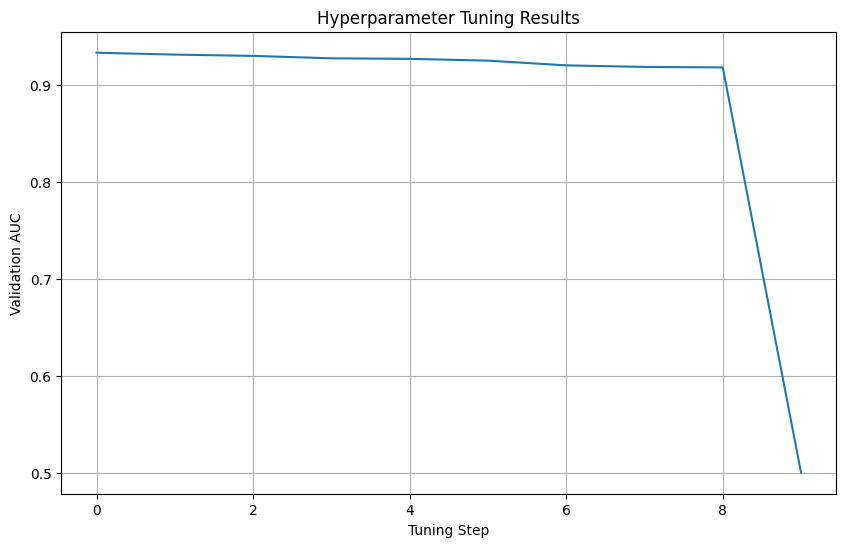

Epoch 1/15
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - auc: 0.8154 - loss: 0.5103 - val_auc: 0.8926 - val_loss: 0.4236
Epoch 2/15
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - auc: 0.8844 - loss: 0.4176 - val_auc: 0.9028 - val_loss: 0.3938
Epoch 3/15
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - auc: 0.8981 - loss: 0.3924 - val_auc: 0.9095 - val_loss: 0.3705
Epoch 4/15
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - auc: 0.9097 - loss: 0.3709 - val_auc: 0.9206 - val_loss: 0.3524
Epoch 5/15
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - auc: 0.9197 - loss: 0.3504 - val_auc: 0.9189 - val_loss: 0.3578
Epoch 6/15
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - auc: 0.9281 - loss: 0.3318 - val_auc: 0.9264 - val_loss: 0.3334
Epoch 7/15
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - auc: 0.9380 - loss: 0.3091 - val_auc: 0.9221 - val_loss: 0.3514
Epoch 8/15
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - auc: 0.9452 - loss: 0.2904 - val_auc: 0.9295 - val_loss: 0.3305
Epoch 9/15
2613/2613 ━━━

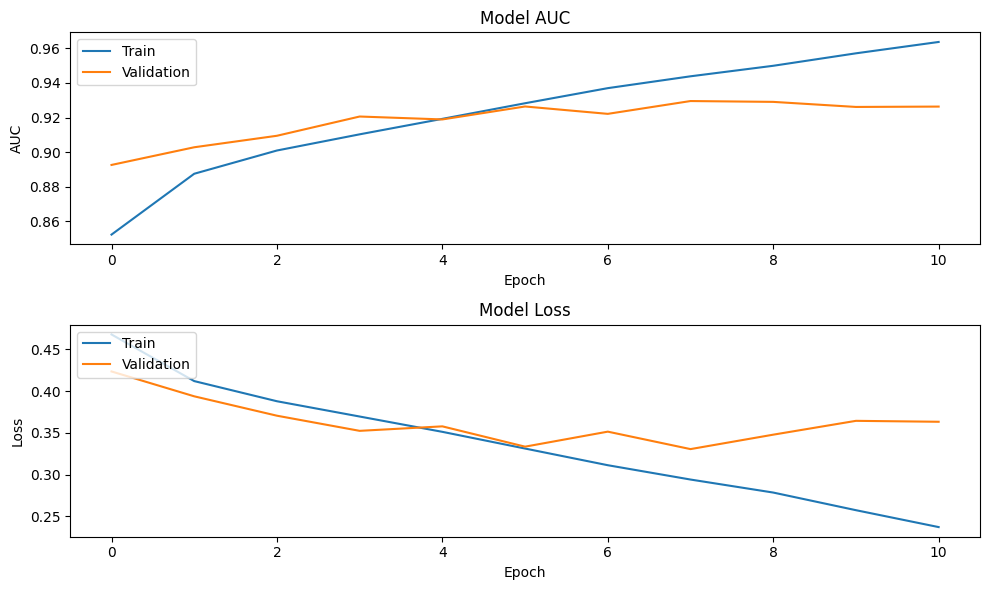

In [26]:
import matplotlib.pyplot as plt


# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#Instantiate a new model with best parameters
best_model = tuner.hypermodel.build(best_hps)


# Get the best trials
best_trials = tuner.oracle.get_best_trials(num_trials=10)

# Extract the validation AUC scores from the best trials
best_trial_scores = [trial.score for trial in best_trials]

# Plot the tuning results using the extracted scores
plt.figure(figsize=(10, 6))
plt.plot(best_trial_scores)
plt.xlabel('Tuning Step')
plt.ylabel('Validation AUC')
plt.title('Hyperparameter Tuning Results')
plt.grid(True)
plt.show()

# Train and plot history of best model using more data for training and less for validation - validation ~ 5%
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
history = best_model.fit(X_train,
                         y_train,
                         epochs=15, validation_split=0.05,
                         shuffle=True,
                         batch_size=64, callbacks=[callback]
                        )

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

##Predict with best model
After finding the best model with hyperparameter tunning is time to predict the test set and generate the submission file

In [30]:

import os
import numpy as np
from PIL import Image
import pandas as pd

# Function to create feature vectors for test images
def create_test_feature_vectors(image_dir):
    image_ids = []
    feature_vectors = []

    for filename in os.listdir(image_dir):
        if filename.endswith(".tif"):
            image_id = filename[:-4]
            image_path = os.path.join(image_dir, filename)

            try:
                img = Image.open(image_path)
                img = img.convert("RGB")

                width, height = img.size
                left = (width - 40) / 2
                top = (height - 40) / 2
                right = (width + 40) / 2
                bottom = (height + 40) / 2
                img = img.crop((left, top, right, bottom))

                pixels = np.array(img) / 255.0

                image_ids.append(image_id)
                feature_vectors.append(pixels)

            except FileNotFoundError:
                print(f"Image not found: {image_path}")
            except Exception as e:
                print(f"Error processing image {image_id}: {e}")

    return np.array(image_ids), np.array(feature_vectors)


# Create feature vectors for test images
test_image_dir = 'test'
test_image_ids, test_feature_vectors = create_test_feature_vectors(test_image_dir)

# Convert to TensorFlow tensors
test_feature_vectors = tf.convert_to_tensor(test_feature_vectors, dtype=tf.float32)



In [31]:
#train the model with best num of epochs and without validation split
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
                X_train,
                y_train,
                epochs=6,
                shuffle=True,
                batch_size=64
              )

# Predict using the best model
predictions = best_model.predict(test_feature_vectors).flatten()
# Convert to 0 or 1 with 0.5 threshold
predictions_binary = (predictions > 0.5).astype(int)


# Create submission DataFrame
submission_df = pd.DataFrame({'id': test_image_ids, 'label': predictions_binary})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

Epoch 1/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - auc: 0.8048 - loss: 0.5192
Epoch 2/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - auc: 0.8860 - loss: 0.4149
Epoch 3/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - auc: 0.9020 - loss: 0.3857
Epoch 4/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - auc: 0.9127 - loss: 0.3644
Epoch 5/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - auc: 0.9225 - loss: 0.3439
Epoch 6/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - auc: 0.9317 - loss: 0.3230
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
